# Solving CartPole-v0 Efficiently with A3C

In this problem, we will return to CartPole-v0, but this time we will employ a different DeepRL strategy known as Asynchronous Advantage Actor-Critic (A3C). A3C tends to offer significantly better results than VPG, as you shall soon see!    

## Part 1: Setup

First, import the necessary packages.

In [2]:
# We have tested these imports on several machines, 
# but depending on your computer, you may need to 
# run some of these imports in your local environment.

# For file saving operations
import os

# For multiple worker threads
from threading import Thread, Lock
import multiprocessing
from queue import Queue

# For math/plotting
import numpy as np
import matplotlib.pyplot as plt

# For testing in simulated environments
!pip install --user gym
import gym

# For training the Actor-Critic model
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers

Processing /Users/jsboygenius/Library/Caches/pip/wheels/05/31/54/501ff9f64e6084bbcb75e600f257f3c628b19f0eaadc37162d/gym-0.17.3-cp36-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e7/e3/898487e5dbeb612054cf2e0c188463acb358167fef749c53c8bb8918cea1/cloudpickle-1.6.0-py3-none-any.whl
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/Users/jsboygenius/Library/Python/3.6'
Check the permissions.

You should consider upgrading via the 'pip install --upgrade pip' command.


ModuleNotFoundError: No module named 'gym'

Next, implement the custom `ActorCriticModel`, which inherits from `keras.Model`.

You will need to initialize the layers for the neural net as follows:
- Dense layer of size 100, with ReLU activation
- Logits output layer
- Dense layer of size 100, with ReLU activation
- Action output layer


In [2]:
class ActorCriticModel(keras.Model):
    def __init__(self, state_size, action_size):
        # Init from keras.Model
        super(ActorCriticModel, self).__init__()
        
        # Constants for available state space and action space sizes
        self.state_size = state_size
        self.action_size = action_size

        ### TODO: Initialize layers for the neural net ###
        self.dense1 = layers.Dense(100, activation='relu')
        self.policy_logits = layers.Dense(action_size)
        self.dense2 = layers.Dense(100, activation='relu')
        self.values = layers.Dense(1)
        
#         self.dense1 = None
#         self.policy_logits = None
#         self.dense2 = None
#         self.values = None
        
        ### TODO ###

    def call(self, inputs):
        # Overloaded from keras.Model
        
        ### TODO: compute forward pass through neural net ###

        x = self.dense1(inputs)
        logits = self.policy_logits(x)
        v1 = self.dense2(inputs)
        values = self.values(v1)
        
#         logits = None
#         values = None

        ### TODO ###
        return logits, values

Now, we have provided you with a `BaseAgent` class from which our DeepRL agents will inherit. Note that the subclassed agent will specify a `train` method (for training the agent) and a `play` method (for playing back a single episode) - you will end up writing parts of these methods!

In [3]:
class BaseAgent:
    """
    Base class from which all custom agents will inherit.
    """
    
    def __init__(self, env_name, num_episodes):
        self.env_name = env_name
        self.env = gym.make(env_name)
        self.num_episodes = num_episodes
        
        self.result_queue = Queue()
        
    def train(self):
        pass
    
    def play(self, render=False):
        pass
    
    def record_episode(self, episode_num, episode_reward, episode_loss, episode_steps, average_reward = 0, worker_idx = None):
        '''
        Helper function to log output about completed episode, while also updating the result queue
        '''
        
        average_reward = average_reward * 0.99 + episode_reward * 0.01 if average_reward > 0 else episode_reward
        
        self.result_queue.put(average_reward)
        
        print(
          f"Episode: {episode_num} | "
          f"Moving Average Reward: {round(average_reward)} | "
          f"Episode Reward: {round(episode_reward)} | "
          f"Loss per step: {round(float(episode_loss) / episode_steps, 3)} | "
          f"Steps: {episode_steps} | "
          f"Worker: {worker_idx}"
        )
        return average_reward

## Part 2: RandomAgent Baseline

Now, you will implement a `RandomAgent` so that we have a baseline performance. This will be very similar to what you have seen on earlier problems.

In [4]:
class RandomAgent(BaseAgent):
    """
    Agent that chooses actions randomly
    """
    def play(self, render=False):
        # Reset environment
        self.env.reset()
        
        total_reward = 0
        steps_taken = 0
        
        done = False
        while not done:
            ### TODO: Choose a random action from the environment's action space ###
            _, reward, done, _ = self.env.step(self.env.action_space.sample())
#             
            ### TODO ###
            
            if render:
                self.env.render() # Only render if requested
            
            total_reward += reward
            steps_taken += 1
        
        self.env.close()        
        return total_reward, steps_taken
    
    def train(self):
        # Since this is a random agent, we won't actually do any real training.
        # Instead, we'll simply run through the episodes using play()
        weighted_average_reward = 0
        total_reward = 0
        for episode in range(self.num_episodes):
            reward, steps = self.play()
            
            weighted_average_reward = self.record_episode(episode, reward, 0, steps, weighted_average_reward)
            
            total_reward += reward 

        simple_average_reward = total_reward / self.num_episodes
        print(f"After {self.num_episodes}, simple average reward is {simple_average_reward} and weighted average reward is {weighted_average_reward}")
        return weighted_average_reward

Now that you've implemented the RandomAgent, let's see what its baseline performance looks like.

In [5]:
random_agent = RandomAgent("CartPole-v0", 100)
random_agent.train()

Episode: 0 | Moving Average Reward: 20 | Episode Reward: 20 | Loss per step: 0.0 | Steps: 20 | Worker: None
Episode: 1 | Moving Average Reward: 20 | Episode Reward: 34 | Loss per step: 0.0 | Steps: 34 | Worker: None
Episode: 2 | Moving Average Reward: 20 | Episode Reward: 46 | Loss per step: 0.0 | Steps: 46 | Worker: None
Episode: 3 | Moving Average Reward: 21 | Episode Reward: 43 | Loss per step: 0.0 | Steps: 43 | Worker: None
Episode: 4 | Moving Average Reward: 21 | Episode Reward: 24 | Loss per step: 0.0 | Steps: 24 | Worker: None
Episode: 5 | Moving Average Reward: 21 | Episode Reward: 34 | Loss per step: 0.0 | Steps: 34 | Worker: None
Episode: 6 | Moving Average Reward: 21 | Episode Reward: 44 | Loss per step: 0.0 | Steps: 44 | Worker: None
Episode: 7 | Moving Average Reward: 21 | Episode Reward: 18 | Loss per step: 0.0 | Steps: 18 | Worker: None
Episode: 8 | Moving Average Reward: 21 | Episode Reward: 16 | Loss per step: 0.0 | Steps: 16 | Worker: None
Episode: 9 | Moving Average 

22.605562560132185

In [6]:
random_agent.play(render=False)

(10.0, 10)

As you saw, the episode ends almost instantly, because the random policy is not very good! With an average reward of only about 20, we are very far away from the required 195 reward to meet OpenAI's criteria for solving `CartPole-v0`.

Let's see how we can use the A3C approach to get significantly better results!

## Part 3: A3C Implementation

First, let's review what the A3C algorithm is. 

A3C stands for **Asynchronous Advantage Actor-Critic**. Let's break it down:
1. **Aysnchronous:** One key advantage of A3C is the comparative speed at which is can be trained compared to other DeepRL methods like DQN. The secret to this speed is a parallelized approach. In A3C, several worker agents are working in parallel on their own individual, local copies of the environment. After several steps, the worker agents update their local models, and then compare their local models to the single global model. If any individual worker has made an improvement to the global model, the global model is updated and all the asynchronous workers synchronize their local models to the new global model. This approach means we can benefit significantly from the speedups in parallel computation. You will learn much more about parallelization in CS 61C!

2. **Advantage:** As you have learned, A3C focuses on estimating the Advantages of actions, exploring parts of the action space that were surprisingly better than expected. Advantage is defined as the difference between a better Q-state and the Value of a state per an existing policy. That is: $$A(s, a) = Q(s, a) - V^\pi(s)$$ Since this math is outside the scope of this project, we will implement the Advantage calculation for you.

3. **Actor-Critic:** The Actor-Critic model is a typical setup for DeepRL, in which an Actor tries to determine the best action from a given state, and in which a Critic evaluates the chosen action for long-term reward. Usually, the Critic is estimating the Value of the state achieved after taking the action. However, in A3C, the Critic instead estimates the Advantage of the state-action pair from the Actor. The interplay between Actor and Critic helps the system converge faster and achieve better results than either system alone.

Now that you have a high-level understanding of what A3C is, let's get into the details and start implementing it!

First, we will create a class representing the Asynchronous Workers that do the heavy lifting in the A3C approach. Each asynchronous worker maintains a local copy of the model and its own environment, and then periodically checks and synchronizes with the global model. 

Since this may be your first exposure to multithreaded programming, we have provided most of that structure for you. :)

In [7]:
class AsyncWorkerAgent(Thread, BaseAgent):
    """
    Aysnchronous worker that trains on an individual instance of the environment
    """

    # Global variables across threads
    mutex = Lock()
    global_episode_idx = 0
    global_moving_average_reward = 0
    best_reward = 0
    
    def __init__(self, worker_idx, env_name, num_episodes, global_model, optimizer, global_result_queue, save_dir, update_frequency=20, gamma=0.99):
        Thread.__init__(self) 
        BaseAgent.__init__(self, env_name, num_episodes)
        
        self.worker_idx = worker_idx
        
        self.global_model = global_model
        self.optimizer = optimizer
        self.result_queue = global_result_queue
        self.save_dir = save_dir
        self.update_frequency = update_frequency 
        self.gamma = gamma # The discount factor for rewards

        ### TODO: Get the size of the state and action spaces from self.env ###
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        
#         self.state_size = None
#         self.action_size = None
        ### TODO ###
    
        self.local_model = ActorCriticModel(self.state_size, self.action_size)
        
        # Reset global variables
        AsyncWorkerAgent.global_episode_idx = 0
        AsyncWorkerAgent.global_moving_average_reward = 0
        AsyncWorkerAgent.best_reward = 0
        
    def run(self):
        # Overloaded from Thread
        self.train()
        
    def train(self):
        # Even though we have multiple workers, the total number of episodes run is still num_episodes
        while AsyncWorkerAgent.global_episode_idx < self.num_episodes:
            episode_idx = AsyncWorkerAgent.global_episode_idx
            current_state = self.env.reset()
        
            total_reward = 0
            total_loss = 0.0
            steps_taken = 0
            
            # Maintain a buffer of the most recent states, actions, and rewards to train the Actor-Critic from
            buffer_states = []
            buffer_actions = []
            buffer_rewards = []

            done = False
            while not done:
                ### TODO: Choose action according to probabilities from neural net ###
                logits, _ = self.local_model(tf.convert_to_tensor(current_state[None, :], dtype=tf.float32))
                probs = tf.nn.softmax(logits)

                action = np.random.choice(self.action_size, p=probs.numpy()[0])

    #           # Note that the action space is discrete, so a valid action is an integer between [0, size of space]
    #           action = None
                ### TODO ###

                new_state, reward, done, _ = self.env.step(action)
                                
                buffer_states.append(current_state)
                buffer_actions.append(action)
                buffer_rewards.append(reward)

                total_reward += reward
                steps_taken += 1

                # Periodically compute gradients to update model
                if steps_taken % self.update_frequency == 0 or done:
                    # We use TensorFlow's GradientTape functionality to track the gradient of our custom loss function
                    with tf.GradientTape() as tape:
                        ### TODO: Use the compute_loss() helper function to obtain the loss ###                        
                        loss = self.compute_loss(done, new_state, buffer_states, buffer_actions, buffer_rewards, self.gamma)
                        #loss = 0
                        ### TODO ###
            
                    buffer_states, buffer_actions, buffer_rewards = [], [], []
                    total_loss += loss

                    # Calculate local gradients
                    grads = tape.gradient(loss, self.local_model.trainable_weights)

                    # Push local gradients to global model
                    self.optimizer.apply_gradients(zip(grads, self.global_model.trainable_weights))
                    
                    # Update local model with new weights
                    self.local_model.set_weights(self.global_model.get_weights())  
                    
                current_state = new_state

            AsyncWorkerAgent.global_moving_average_reward = \
                  self.record_episode(episode_idx, total_reward, total_loss, steps_taken, AsyncWorkerAgent.global_moving_average_reward, self.worker_idx)

            # Check if our local model has surpassed 
            if total_reward > AsyncWorkerAgent.best_reward:
                # Acquire the mutex to save weights without any data races
                with AsyncWorkerAgent.mutex:
                    weights_file = os.path.join(self.save_dir,
                                     f'model_{self.env_name}_{total_reward}.h5')
                    print(f"Saving best model to {weights_file}, episode score: {total_reward}")
                    self.global_model.save_weights(weights_file)
                    AsyncWorkerAgent.best_reward = total_reward
            
            AsyncWorkerAgent.global_episode_idx += 1
                

    def compute_loss(self, done, state, prev_states, prev_actions, prev_rewards, gamma):
        """
        Helper function to compute custom loss for A3C.
        """
        ### TODO: Initialize reward_sum based on the expected future reward from the current state ###
        if done:
            reward_sum = 0  # terminal
        else:
            reward_sum = self.local_model(tf.convert_to_tensor(state[None, :], dtype=tf.float32))[-1].numpy()[0]
        
#         if done:
#             reward_sum = 0
#         else:
#             reward_sum = 0
        ### TODO ###

        ### TODO: Discount previous rewards using discount factor
        discounted_rewards = []
        for reward in prev_rewards[::-1]:
            reward_sum = reward + gamma * reward_sum
            discounted_rewards.append(reward_sum)
        discounted_rewards.reverse()
        
#         discounted_rewards = []
        ### TODO ###

        ### TODO: Compute the logits and values using our local model ###
        logits, values = self.local_model(tf.convert_to_tensor(np.vstack(prev_states), dtype=tf.float32))
#         logits, values = None, None
        ### TODO ###
        
        # Get our advantages
        advantage = tf.convert_to_tensor(np.array(discounted_rewards)[:, None],
                                dtype=tf.float32) - values
        # Value loss
        value_loss = advantage ** 2

        # Calculate our policy loss
        policy = tf.nn.softmax(logits)
        entropy = tf.nn.softmax_cross_entropy_with_logits(labels=policy, logits=logits)

        policy_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=prev_actions,
                                                                     logits=logits)
        policy_loss *= tf.stop_gradient(advantage)
        policy_loss -= 0.01 * entropy
        total_loss = tf.reduce_mean((0.5 * value_loss + policy_loss))
        return total_loss

Now that you've built the individual Asynchronous workers, it's time to build the master A3C agent that will put the workers to work!

In [8]:
class A3CAgent(BaseAgent):
    """
    Agent that uses Asynchronous Advantage Actor-Critic (A3C) method for learning
    """
    def __init__(self, env_name, num_episodes):
        # Call base constructor
        super().__init__(env_name, num_episodes)

        self.save_dir = "/tmp/"
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

        ### TODO: Get the size of the state and action spaces from self.env ###
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        
#         self.state_size = None
#         self.action_size = None
        ### TODO ###
        
        learning_rate = 0.001
        ### TODO: Initialize Adam optimizer with learning rate 0.001 ###
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate, use_locking=True)       
#         self.optimizer = None
        ### TODO ###
        
        ### TODO: Create an ActorCritic model using our custom class, and initialize it with random data ###
        self.global_model = ActorCriticModel(self.state_size, self.action_size)  
        self.global_model(tf.convert_to_tensor(np.random.random((1, self.state_size)), dtype=tf.float32))
        #         self.global_model = None
        ### TODO ###        
        
    def train(self):

        ### TODO: Create 4 workers and store them in this list ###
        # (Normally, we would limit based on number of cores on the computer for parallelization)
        workers = [ AsyncWorkerAgent(i, self.env_name, self.num_episodes, self.global_model, self.optimizer, self.result_queue, self.save_dir) 
                           for i in range(4)] 
#         workers = []
        ### TODO ###
        for i, worker in enumerate(workers):
            print(f"Starting worker {i}")
            worker.start()
            
        # Wait for all workers to finish
        [w.join() for w in workers]
        
        ### TODO: Plot a graph of rewards from self.result_queue over time ### 
        plt.plot(list(self.result_queue.queue))
        plt.ylabel('Moving average rewards')
        plt.xlabel('Step')
        plt.savefig(os.path.join(self.save_dir,
                                 '{} Moving Average.png'.format(self.env_name)))
        plt.show()
#         pass
        ###
    
    def play(self, render=False, model_path=""):
        # If desired, load model from file
        if model_path != "":
            model_path = os.path.join(self.save_dir, model_path)
            print(f'Loading model from: {model_path}')
            self.global_model.load_weights(model_path)

        # Reset environment
        state = self.env.reset()
        
        total_reward = 0
        steps_taken = 0
        
        done = False
        while not done:
            ### TODO: Extract the logits and value from the global model ###
            logits, value = self.global_model(tf.convert_to_tensor(state[None, :], dtype=tf.float32))
            policy = tf.nn.softmax(logits)

#             logits, value = None, None
#             policy = None
            ### TODO ###
            
            ### TODO: Identify optimal action from policy ###
            action = np.argmax(policy)
#             action = None
            ### TODO ###
            
            state, reward, done, _ = self.env.step(action)
        
            if render:
                self.env.render() # Only render if requested
            
            total_reward += reward
            steps_taken += 1

            print(f"Step {steps_taken}: Total Reward: {total_reward}, Action: {action}")
        
        self.env.close()
        return total_reward, steps_taken


Great work! Time to train the agent with 1000 episodes. **This will take a while.**

Episode: 278 | Moving Average Reward: 87 | Episode Reward: 200 | Loss per step: 2.996 | Steps: 200 | Worker: 0
Episode: 279 | Moving Average Reward: 88 | Episode Reward: 200 | Loss per step: 3.341 | Steps: 200 | Worker: 1
Starting worker 0
Starting worker 1
Starting worker 2
Starting worker 3
Episode: 0 | Moving Average Reward: 11 | Episode Reward: 11 | Loss per step: 2.352 | Steps: 11 | Worker: 1
Saving best model to /tmp/model_CartPole-v0_11.0.h5, episode score: 11.0
Episode: 0 | Moving Average Reward: 11 | Episode Reward: 13 | Loss per step: 2.45 | Steps: 13 | Worker: 2
Episode: 0 | Moving Average Reward: 11 | Episode Reward: 19 | Loss per step: 3.368 | Steps: 19 | Worker: 0Saving best model to /tmp/model_CartPole-v0_13.0.h5, episode score: 13.0

Saving best model to /tmp/model_CartPole-v0_19.0.h5, episode score: 19.0
Episode: 0 | Moving Average Reward: 11 | Episode Reward: 28 | Loss per step: 2.999 | Steps: 28 | Worker: 3
Saving best model to /tmp/model_CartPole-v0_28.0.h5, episode

Episode: 70 | Moving Average Reward: 28 | Episode Reward: 20 | Loss per step: 2.921 | Steps: 20 | Worker: 2
Episode: 66 | Moving Average Reward: 29 | Episode Reward: 58 | Loss per step: 3.094 | Steps: 58 | Worker: 1
Episode: 75 | Moving Average Reward: 28 | Episode Reward: 13 | Loss per step: 1.615 | Steps: 13 | Worker: 2
Episode: 76 | Moving Average Reward: 28 | Episode Reward: 14 | Loss per step: 2.141 | Steps: 14 | Worker: 1
Episode: 74 | Moving Average Reward: 28 | Episode Reward: 21 | Loss per step: 3.315 | Steps: 21 | Worker: 0
Episode: 72 | Moving Average Reward: 28 | Episode Reward: 33 | Loss per step: 2.986 | Steps: 33 | Worker: 3
Episode: 77 | Moving Average Reward: 28 | Episode Reward: 18 | Loss per step: 2.615 | Steps: 18 | Worker: 2
Episode: 48 | Moving Average Reward: 30 | Episode Reward: 200 | Loss per step: 3.382 | Steps: 200 | Worker: 2
Episode: 79 | Moving Average Reward: 30 | Episode Reward: 15 | Loss per step: 1.898 | Steps: 15 | Worker: 0
Episode: 80 | Moving Avera

Episode: 149 | Moving Average Reward: 38 | Episode Reward: 19 | Loss per step: 1.778 | Steps: 19 | Worker: 3
Episode: 153 | Moving Average Reward: 38 | Episode Reward: 19 | Loss per step: 1.677 | Steps: 19 | Worker: 1
Episode: 148 | Moving Average Reward: 38 | Episode Reward: 50 | Loss per step: 15.075 | Steps: 50 | Worker: 3
Episode: 155 | Moving Average Reward: 38 | Episode Reward: 23 | Loss per step: 2.958 | Steps: 23 | Worker: 3
Episode: 152 | Moving Average Reward: 38 | Episode Reward: 43 | Loss per step: 2.938 | Steps: 43 | Worker: 2
Episode: 156 | Moving Average Reward: 38 | Episode Reward: 26 | Loss per step: 2.523 | Steps: 26 | Worker: 1
Episode: 144 | Moving Average Reward: 38 | Episode Reward: 100 | Loss per step: 5.78 | Steps: 100 | Worker: 2
Episode: 159 | Moving Average Reward: 38 | Episode Reward: 17 | Loss per step: 1.331 | Steps: 17 | Worker: 2
Episode: 160 | Moving Average Reward: 38 | Episode Reward: 18 | Loss per step: 1.454 | Steps: 18 | Worker: 1
Episode: 158 | Mo

Episode: 228 | Moving Average Reward: 54 | Episode Reward: 22 | Loss per step: 4.267 | Steps: 22 | Worker: 1
Episode: 226 | Moving Average Reward: 54 | Episode Reward: 66 | Loss per step: 2.819 | Steps: 66 | Worker: 2
Episode: 223 | Moving Average Reward: 55 | Episode Reward: 118 | Loss per step: 2.508 | Steps: 118 | Worker: 0
Episode: 230 | Moving Average Reward: 54 | Episode Reward: 44 | Loss per step: 3.27 | Steps: 44 | Worker: 3
Episode: 217 | Moving Average Reward: 56 | Episode Reward: 200 | Loss per step: 2.468 | Steps: 200 | Worker: 0
Episode: 231 | Moving Average Reward: 56 | Episode Reward: 56 | Loss per step: 2.209 | Steps: 56 | Worker: 1
Episode: 232 | Moving Average Reward: 56 | Episode Reward: 41 | Loss per step: 4.365 | Steps: 41 | Worker: 2
Episode: 222 | Moving Average Reward: 57 | Episode Reward: 165 | Loss per step: 3.528 | Steps: 165 | Worker: 3
Episode: 234 | Moving Average Reward: 57 | Episode Reward: 33 | Loss per step: 2.094 | Steps: 33 | Worker: 3
Episode: 237 |

Episode: 296 | Moving Average Reward: 80 | Episode Reward: 143 | Loss per step: 2.392 | Steps: 143 | Worker: 3
Episode: 300 | Moving Average Reward: 80 | Episode Reward: 87 | Loss per step: 4.112 | Steps: 87 | Worker: 0
Episode: 295 | Moving Average Reward: 81 | Episode Reward: 187 | Loss per step: 2.062 | Steps: 187 | Worker: 1
Episode: 305 | Moving Average Reward: 80 | Episode Reward: 61 | Loss per step: 6.1 | Steps: 61 | Worker: 3
Episode: 304 | Moving Average Reward: 81 | Episode Reward: 83 | Loss per step: 3.452 | Steps: 83 | Worker: 1
Episode: 301 | Moving Average Reward: 81 | Episode Reward: 126 | Loss per step: 4.439 | Steps: 126 | Worker: 2
Episode: 307 | Moving Average Reward: 81 | Episode Reward: 61 | Loss per step: 5.664 | Steps: 61 | Worker: 0
Episode: 298 | Moving Average Reward: 82 | Episode Reward: 200 | Loss per step: 2.36 | Steps: 200 | Worker: 2
Episode: 310 | Moving Average Reward: 82 | Episode Reward: 49 | Loss per step: 4.266 | Steps: 49 | Worker: 1
Episode: 303 |

Episode: 371 | Moving Average Reward: 127 | Episode Reward: 200 | Loss per step: 2.622 | Steps: 200 | Worker: 1
Episode: 373 | Moving Average Reward: 128 | Episode Reward: 181 | Loss per step: 1.535 | Steps: 181 | Worker: 0
Episode: 374 | Moving Average Reward: 128 | Episode Reward: 200 | Loss per step: 2.628 | Steps: 200 | Worker: 0
Episode: 376 | Moving Average Reward: 129 | Episode Reward: 200 | Loss per step: 1.505 | Steps: 200 | Worker: 1
Episode: 377 | Moving Average Reward: 130 | Episode Reward: 190 | Loss per step: 1.35 | Steps: 190 | Worker: 3
Episode: 378 | Moving Average Reward: 130 | Episode Reward: 200 | Loss per step: 3.059 | Steps: 200 | Worker: 3
Episode: 379 | Moving Average Reward: 131 | Episode Reward: 200 | Loss per step: 2.519 | Steps: 200 | Worker: 2
Episode: 380 | Moving Average Reward: 132 | Episode Reward: 200 | Loss per step: 2.801 | Steps: 200 | Worker: 2
Episode: 382 | Moving Average Reward: 133 | Episode Reward: 200 | Loss per step: 1.494 | Steps: 200 | Wor

Episode: 449 | Moving Average Reward: 150 | Episode Reward: 148 | Loss per step: 5.62 | Steps: 148 | Worker: 3
Episode: 447 | Moving Average Reward: 150 | Episode Reward: 200 | Loss per step: 2.346 | Steps: 200 | Worker: 3
Episode: 448 | Moving Average Reward: 151 | Episode Reward: 191 | Loss per step: 0.836 | Steps: 191 | Worker: 1
Episode: 450 | Moving Average Reward: 151 | Episode Reward: 200 | Loss per step: 3.524 | Steps: 200 | Worker: 0
Episode: 452 | Moving Average Reward: 151 | Episode Reward: 130 | Loss per step: 6.524 | Steps: 130 | Worker: 1
Episode: 451 | Moving Average Reward: 152 | Episode Reward: 197 | Loss per step: 3.861 | Steps: 197 | Worker: 2
Episode: 455 | Moving Average Reward: 151 | Episode Reward: 128 | Loss per step: 5.778 | Steps: 128 | Worker: 3
Episode: 453 | Moving Average Reward: 152 | Episode Reward: 200 | Loss per step: 1.51 | Steps: 200 | Worker: 2
Episode: 454 | Moving Average Reward: 152 | Episode Reward: 200 | Loss per step: 2.737 | Steps: 200 | Work

Episode: 525 | Moving Average Reward: 171 | Episode Reward: 200 | Loss per step: 3.967 | Steps: 200 | Worker: 3
Episode: 529 | Moving Average Reward: 171 | Episode Reward: 136 | Loss per step: 7.547 | Steps: 136 | Worker: 3
Episode: 526 | Moving Average Reward: 171 | Episode Reward: 200 | Loss per step: 4.863 | Steps: 200 | Worker: 0
Episode: 527 | Moving Average Reward: 172 | Episode Reward: 200 | Loss per step: 4.848 | Steps: 200 | Worker: 1
Episode: 528 | Moving Average Reward: 172 | Episode Reward: 200 | Loss per step: 2.788 | Steps: 200 | Worker: 2
Episode: 533 | Moving Average Reward: 171 | Episode Reward: 54 | Loss per step: 14.076 | Steps: 54 | Worker: 2
Episode: 530 | Moving Average Reward: 171 | Episode Reward: 200 | Loss per step: 4.147 | Steps: 200 | Worker: 3
Episode: 532 | Moving Average Reward: 171 | Episode Reward: 200 | Loss per step: 4.904 | Steps: 200 | Worker: 1
Episode: 531 | Moving Average Reward: 171 | Episode Reward: 200 | Loss per step: 4.082 | Steps: 200 | Wor

Episode: 600 | Moving Average Reward: 182 | Episode Reward: 200 | Loss per step: 4.849 | Steps: 200 | Worker: 0
Episode: 601 | Moving Average Reward: 182 | Episode Reward: 200 | Loss per step: 4.363 | Steps: 200 | Worker: 1
Episode: 602 | Moving Average Reward: 182 | Episode Reward: 200 | Loss per step: 4.517 | Steps: 200 | Worker: 2
Episode: 603 | Moving Average Reward: 182 | Episode Reward: 200 | Loss per step: 4.494 | Steps: 200 | Worker: 3
Episode: 604 | Moving Average Reward: 183 | Episode Reward: 200 | Loss per step: 4.219 | Steps: 200 | Worker: 0
Episode: 605 | Moving Average Reward: 183 | Episode Reward: 200 | Loss per step: 3.853 | Steps: 200 | Worker: 1
Episode: 606 | Moving Average Reward: 183 | Episode Reward: 200 | Loss per step: 4.168 | Steps: 200 | Worker: 2
Episode: 607 | Moving Average Reward: 183 | Episode Reward: 200 | Loss per step: 3.866 | Steps: 200 | Worker: 3
Episode: 608 | Moving Average Reward: 183 | Episode Reward: 200 | Loss per step: 4.006 | Steps: 200 | Wo

Episode: 676 | Moving Average Reward: 191 | Episode Reward: 200 | Loss per step: 4.046 | Steps: 200 | Worker: 0
Episode: 677 | Moving Average Reward: 191 | Episode Reward: 200 | Loss per step: 4.644 | Steps: 200 | Worker: 1
Episode: 678 | Moving Average Reward: 191 | Episode Reward: 200 | Loss per step: 5.218 | Steps: 200 | Worker: 2
Episode: 679 | Moving Average Reward: 192 | Episode Reward: 200 | Loss per step: 4.474 | Steps: 200 | Worker: 3
Episode: 680 | Moving Average Reward: 192 | Episode Reward: 200 | Loss per step: 5.224 | Steps: 200 | Worker: 0
Episode: 681 | Moving Average Reward: 192 | Episode Reward: 200 | Loss per step: 4.392 | Steps: 200 | Worker: 1
Episode: 683 | Moving Average Reward: 192 | Episode Reward: 200 | Loss per step: 2.99 | Steps: 200 | Worker: 3
Episode: 682 | Moving Average Reward: 192 | Episode Reward: 200 | Loss per step: 5.395 | Steps: 200 | Worker: 2
Episode: 684 | Moving Average Reward: 192 | Episode Reward: 200 | Loss per step: 4.173 | Steps: 200 | Wor

Episode: 752 | Moving Average Reward: 189 | Episode Reward: 150 | Loss per step: 2.059 | Steps: 150 | Worker: 1
Episode: 754 | Moving Average Reward: 188 | Episode Reward: 111 | Loss per step: 1.798 | Steps: 111 | Worker: 2
Episode: 753 | Moving Average Reward: 187 | Episode Reward: 122 | Loss per step: 1.963 | Steps: 122 | Worker: 3
Episode: 755 | Moving Average Reward: 187 | Episode Reward: 156 | Loss per step: 2.134 | Steps: 156 | Worker: 0
Episode: 757 | Moving Average Reward: 186 | Episode Reward: 54 | Loss per step: 14.949 | Steps: 54 | Worker: 2
Episode: 756 | Moving Average Reward: 185 | Episode Reward: 128 | Loss per step: 1.675 | Steps: 128 | Worker: 1
Episode: 759 | Moving Average Reward: 185 | Episode Reward: 139 | Loss per step: 1.138 | Steps: 139 | Worker: 0
Episode: 758 | Moving Average Reward: 185 | Episode Reward: 188 | Loss per step: 1.551 | Steps: 188 | Worker: 3
Episode: 760 | Moving Average Reward: 184 | Episode Reward: 143 | Loss per step: 1.642 | Steps: 143 | Wor

Episode: 827 | Moving Average Reward: 184 | Episode Reward: 200 | Loss per step: 2.213 | Steps: 200 | Worker: 0
Episode: 828 | Moving Average Reward: 184 | Episode Reward: 200 | Loss per step: 0.956 | Steps: 200 | Worker: 3
Episode: 829 | Moving Average Reward: 184 | Episode Reward: 200 | Loss per step: 0.743 | Steps: 200 | Worker: 2
Episode: 830 | Moving Average Reward: 184 | Episode Reward: 200 | Loss per step: 4.808 | Steps: 200 | Worker: 1
Episode: 831 | Moving Average Reward: 184 | Episode Reward: 200 | Loss per step: 8.016 | Steps: 200 | Worker: 0
Episode: 832 | Moving Average Reward: 185 | Episode Reward: 200 | Loss per step: 1.418 | Steps: 200 | Worker: 3
Episode: 833 | Moving Average Reward: 185 | Episode Reward: 200 | Loss per step: 3.63 | Steps: 200 | Worker: 2
Episode: 834 | Moving Average Reward: 185 | Episode Reward: 200 | Loss per step: 6.388 | Steps: 200 | Worker: 1
Episode: 835 | Moving Average Reward: 185 | Episode Reward: 200 | Loss per step: 7.194 | Steps: 200 | Wor

Episode: 902 | Moving Average Reward: 190 | Episode Reward: 195 | Loss per step: 0.935 | Steps: 195 | Worker: 1
Episode: 903 | Moving Average Reward: 190 | Episode Reward: 187 | Loss per step: 1.14 | Steps: 187 | Worker: 0
Episode: 904 | Moving Average Reward: 190 | Episode Reward: 200 | Loss per step: 2.013 | Steps: 200 | Worker: 3
Episode: 905 | Moving Average Reward: 190 | Episode Reward: 200 | Loss per step: 0.888 | Steps: 200 | Worker: 2
Episode: 907 | Moving Average Reward: 190 | Episode Reward: 177 | Loss per step: 0.978 | Steps: 177 | Worker: 0
Episode: 906 | Moving Average Reward: 190 | Episode Reward: 200 | Loss per step: 2.658 | Steps: 200 | Worker: 1
Episode: 908 | Moving Average Reward: 190 | Episode Reward: 200 | Loss per step: 1.19 | Steps: 200 | Worker: 3
Episode: 909 | Moving Average Reward: 191 | Episode Reward: 200 | Loss per step: 0.935 | Steps: 200 | Worker: 2
Episode: 910 | Moving Average Reward: 191 | Episode Reward: 200 | Loss per step: 3.374 | Steps: 200 | Work

Episode: 978 | Moving Average Reward: 192 | Episode Reward: 200 | Loss per step: 6.34 | Steps: 200 | Worker: 1
Episode: 980 | Moving Average Reward: 192 | Episode Reward: 200 | Loss per step: 6.377 | Steps: 200 | Worker: 3
Episode: 979 | Moving Average Reward: 192 | Episode Reward: 200 | Loss per step: 6.179 | Steps: 200 | Worker: 0
Episode: 981 | Moving Average Reward: 192 | Episode Reward: 200 | Loss per step: 6.444 | Steps: 200 | Worker: 2
Episode: 982 | Moving Average Reward: 192 | Episode Reward: 200 | Loss per step: 6.614 | Steps: 200 | Worker: 1
Episode: 983 | Moving Average Reward: 192 | Episode Reward: 200 | Loss per step: 5.88 | Steps: 200 | Worker: 3
Episode: 984 | Moving Average Reward: 193 | Episode Reward: 200 | Loss per step: 6.315 | Steps: 200 | Worker: 0
Episode: 985 | Moving Average Reward: 193 | Episode Reward: 200 | Loss per step: 6.095 | Steps: 200 | Worker: 2
Episode: 986 | Moving Average Reward: 193 | Episode Reward: 200 | Loss per step: 6.37 | Steps: 200 | Worke

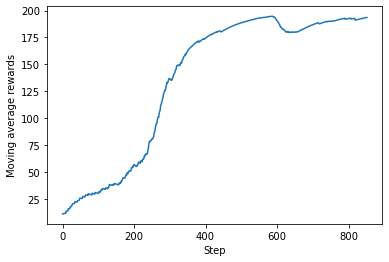

In [10]:
agent = A3CAgent("CartPole-v0", 1000)
agent.train()

## Self-check:

You should observe that the agent converges to a solution near the maximum reward of 200. OpenAI formally defines 'solving' CartPole once your algorithm achieves a running average of 195.0 reward or higher for 100 episodes. Depending on some random seeding, you may observe that your model doesn't exactly meet this requirement, but as long as the individual episode rewards are near 200 you are fine.

If your solution is lagging significantly below the 200 reward level, check to make sure that your loss function is implemented as per the specifications, as this is the most common student error.

Let's see what that looks like in action.

In [11]:
# In case you need to re-run this cell because of a notebook crash, you can load training weights from a file
# Either scroll through the training output or scan through the save directory for the weights with best performance
# agent.play(render=True, model_path="/tmp/model_CartPole-v0_200.0.h5")

agent.play(render=True)

Step 1: Total Reward: 1.0, Action: 0
Step 2: Total Reward: 2.0, Action: 0
Step 3: Total Reward: 3.0, Action: 1
Step 4: Total Reward: 4.0, Action: 0
Step 5: Total Reward: 5.0, Action: 1
Step 6: Total Reward: 6.0, Action: 1
Step 7: Total Reward: 7.0, Action: 0
Step 8: Total Reward: 8.0, Action: 1
Step 9: Total Reward: 9.0, Action: 0
Step 10: Total Reward: 10.0, Action: 1
Step 11: Total Reward: 11.0, Action: 0
Step 12: Total Reward: 12.0, Action: 1
Step 13: Total Reward: 13.0, Action: 0
Step 14: Total Reward: 14.0, Action: 1
Step 15: Total Reward: 15.0, Action: 0
Step 16: Total Reward: 16.0, Action: 1
Step 17: Total Reward: 17.0, Action: 0
Step 18: Total Reward: 18.0, Action: 1
Step 19: Total Reward: 19.0, Action: 0
Step 20: Total Reward: 20.0, Action: 1
Step 21: Total Reward: 21.0, Action: 0
Step 22: Total Reward: 22.0, Action: 1
Step 23: Total Reward: 23.0, Action: 0
Step 24: Total Reward: 24.0, Action: 1
Step 25: Total Reward: 25.0, Action: 1
Step 26: Total Reward: 26.0, Action: 0
Step

(200.0, 200)

Congratulations! If your model looks good qualitatively, you are done!